In [62]:
import yfinance as yf
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

##N-BEATS


In [63]:
input_size = 10
backcast_length = 10
forecast_length = 5
hidden_units = 128
num_blocks = 4
num_layers = 4
num_stacks = 4

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self,
                  input_size: int,
                  backcast_length: int,
                  forecast_length: int,
                  hidden_units: int,
                  hidden_layers: int):
        super(Block, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
    
        layers = []
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(nn.ReLU())
            input_size = hidden_units
        layers.append(nn.Linear( hidden_units, backcast_length + forecast_length))
        self.model = nn.Sequential(*layers)
    
    def forward(self,x):
        y = self.model(x)
        y_1d = y.squeeze()
        backcast, forecast =torch.split(y_1d, [self.backcast_length, self.forecast_length], dim=0)
        return backcast, forecast
    
class NbeatsStack(nn.Module):
    def __init__(self, 
                 input_size: int,
                 backcast_length: int,
                 forecast_length: int,
                 hidden_units: int,
                 hidden_layers: int,
                 num_blocks: int,
                 ):
        super(NbeatsStack, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

        self.blocks = nn.ModuleList([Block(input_size, backcast_length, forecast_length, hidden_units, hidden_layers) for _ in range(num_blocks)])
    
    def forward(self, x):
        backcasts = []
        forecasts = []
        for block in self.blocks:
       
            backcast, forecast = block(x)
            backcasts.append(backcast.unsqueeze(1))
            forecasts.append(forecast.unsqueeze(1))
            x = torch.cat([x.squeeze(), backcast.unsqueeze(1).squeeze()], dim=0)
      

            backcasts = torch.cat(backcasts, dim=1)
            forecasts = torch.cat(forecasts, dim=1)
            return backcasts, forecasts
        
class Nbeat(nn.Module):
    def __init__(self, 
                 input_size: int,
                 backcast_length: int,
                 forecast_length: int,
                 hidden_units: int,
                 hidden_layers: int,
                 num_blocks: int,
                 num_stacks: int
                 ):
        super(Nbeat, self).__init__()
        

        self.stacks = nn.ModuleList([NbeatsStack(input_size, backcast_length, forecast_length, hidden_units, hidden_layers, num_blocks) for _ in range(num_stacks)])

    def forward(self, x):
        backcasts = []
        forecasts = []
        for stack in self.stacks:
            backcast, forecast = stack(x)
            forecasts.append(forecast.squeeze())
            x = backcast.squeeze()
        print("forecasts", forecasts)
        fc = torch.mean(torch.stack(forecasts), dim=0)
        return backcast, fc


##Get Data

In [65]:
GetFacebookInformation = yf.Ticker("META")
facebook_history = GetFacebookInformation.history(period="max")
print(facebook_history)


                                 Open        High         Low       Close  \
Date                                                                        
2012-05-18 00:00:00-04:00   42.049999   45.000000   38.000000   38.230000   
2012-05-21 00:00:00-04:00   36.529999   36.660000   33.000000   34.029999   
2012-05-22 00:00:00-04:00   32.610001   33.590000   30.940001   31.000000   
2012-05-23 00:00:00-04:00   31.370001   32.500000   31.360001   32.000000   
2012-05-24 00:00:00-04:00   32.950001   33.209999   31.770000   33.029999   
...                               ...         ...         ...         ...   
2024-02-14 00:00:00-05:00  467.929993  474.109985  466.089996  473.279999   
2024-02-15 00:00:00-05:00  475.279999  488.619995  472.220001  484.029999   
2024-02-16 00:00:00-05:00  478.109985  478.959991  469.209991  473.320007   
2024-02-20 00:00:00-05:00  469.720001  476.179993  466.559998  471.750000   
2024-02-21 00:00:00-05:00  469.714996  467.725006  461.790009  465.583313   

In [66]:
train_data_set = facebook_history[:2800]
test_data_set = facebook_history[2800:]

In [67]:
#x_train = []
#y_train = []
#for i in range(backcast_length, len(train_data_set) - forecast_length):
#    x_res = []
#    for b in range(backcast_length):
#        x_res.append(train_data_set.iloc[i - backcast_length + b, 1].tolist())
#    x_train.append(x_res)
#
#    y_res = []
#    for f in range(forecast_length):
#        y_res.append(train_data_set.iloc[i + f, 1].tolist())
#    y_train.append(y_res)

In [68]:
#Pre-process data
def pre_process(dataset, backcast, forecast):
    x_l = []
    y_l = []

    for i in range(backcast, len(dataset) - forecast):
        x = []
        for b in range(backcast):
            x.append(dataset.iloc[i - backcast + b, 1].tolist())
        x_l.append(x)

        y = []
        for f in range(forecast_length):
            y.append(dataset.iloc[i + f, 1].tolist())
        y_l.append(y)

    return x_l,y_l

x_train, y_train = pre_process(train_data_set, backcast_length, forecast_length)
x_test, y_test = pre_process(test_data_set, backcast_length, forecast_length)


In [69]:
print(x_train)
print(y_train)
print(x_test)
print(y_test)

[[45.0, 36.65999984741211, 33.59000015258789, 32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273], [36.65999984741211, 33.59000015258789, 32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273], [33.59000015258789, 32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273, 27.760000228881836], [32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273, 27.760000228881836, 27.170000076293945], [33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273, 27.760000228881836, 27.170000076293945, 27.350000381469727], [32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000

##Define model


In [88]:
model = Nbeat(input_size,
                    backcast_length,
                    forecast_length,
                    hidden_units,
                    num_layers,
                    num_blocks,
                    num_stacks)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Nbeat(
  (stacks): ModuleList(
    (0-3): 4 x NbeatsStack(
      (blocks): ModuleList(
        (0-3): 4 x Block(
          (model): Sequential(
            (0): Linear(in_features=10, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=128, bias=True)
            (5): ReLU()
            (6): Linear(in_features=128, out_features=128, bias=True)
            (7): ReLU()
            (8): Linear(in_features=128, out_features=15, bias=True)
          )
        )
      )
    )
  )
)


In [91]:
##Train
num_epochs = 1
train_outputs = []
for epoch in range(num_epochs):
    model.train()
    for i in range(len(x_train)):
        x = torch.Tensor(x_train[i])
        y = torch.Tensor(y_train[i])
        optimizer.zero_grad()
        backcasts, forecasts = model(x)
       
        train_outputs.append(forecasts.squeeze().tolist()[0])
        loss = criterion(forecasts.squeeze(), y)
        loss.backward()
        optimizer.step()
    print(epoch)
    

        

forecasts [tensor([-0.5528, -0.3797, -0.1644, -0.0886,  0.5748],
       grad_fn=<SqueezeBackward0>), tensor([ 0.0593, -0.0251, -0.0362,  0.0489, -0.0484],
       grad_fn=<SqueezeBackward0>), tensor([ 0.0801, -0.0927,  0.0007, -0.0319,  0.0937],
       grad_fn=<SqueezeBackward0>), tensor([-0.0820, -0.0440,  0.0888, -0.0558, -0.0209],
       grad_fn=<SqueezeBackward0>)]
FFEFEF tensor(-0.0338, grad_fn=<MeanBackward0>)


TypeError: 'float' object is not subscriptable

In [72]:
print(train_outputs)


[0.05399172008037567, 0.07042056322097778, 0.0860660970211029, 0.10180090367794037, 0.11675651371479034, 0.1340349316596985, 0.15519440174102783, 0.17989301681518555, 0.20955774188041687, 0.24721933901309967, 0.2953994572162628, 0.3606944978237152, 0.4592398405075073, 0.6219357252120972, 0.9202501177787781, 1.4862327575683594, 2.5971381664276123, 4.817035675048828, 9.23930549621582, 18.11168670654297, 36.64220428466797, 66.03886413574219, 49.60453414916992, 33.82876205444336, 24.040180206298828, 18.661741256713867, 15.800814628601074, 14.36913776397705, 14.005152702331543, 14.480299949645996, 15.75545597076416, 17.8518123626709, 21.1661376953125, 25.828044891357422, 31.41958999633789, 36.071563720703125, 37.050437927246094, 33.730995178222656, 28.190675735473633, 22.594627380371094, 18.438663482666016, 15.619041442871094, 13.594549179077148, 12.299071311950684, 11.665145874023438, 11.41152286529541, 11.498077392578125, 11.830937385559082, 12.52005672454834, 13.761343002319336, 15.43084

[27.649999618530273, 27.760000228881836, 27.170000076293945, 27.350000381469727, 27.760000228881836, 28.06999969482422, 27.770000457763672, 28.100000381469727, 28.31999969482422, 30.100000381469727, 32.08000183105469, 32.18000030517578, 31.93000030517578, 32.5, 33.45000076293945, 33.02000045776367, 33.439998626708984, 32.900001525878906, 32.189998626708984, 31.989999771118164, 31.729999542236328, 31.440000534057617, 31.6299991607666, 31.899999618530273, 32.880001068115234, 32.47999954223633, 31.559999465942383, 31.399999618530273, 31.06999969482422, 30.5, 28.59000015258789, 29.290000915527344, 29.5, 29.469999313354492, 29.0, 29.450000762939453, 29.489999771118164, 28.229999542236328, 24.540000915527344, 24.040000915527344, 23.3700008392334, 21.579999923706055, 20.84000015258789, 22.15999984741211, 22.149999618530273, 22.450000762939453, 21.149999618530273, 21.170000076293945, 21.81999969482422, 22.450000762939453, 21.600000381469727, 21.40999984741211, 20.479999542236328, 20.0799999237

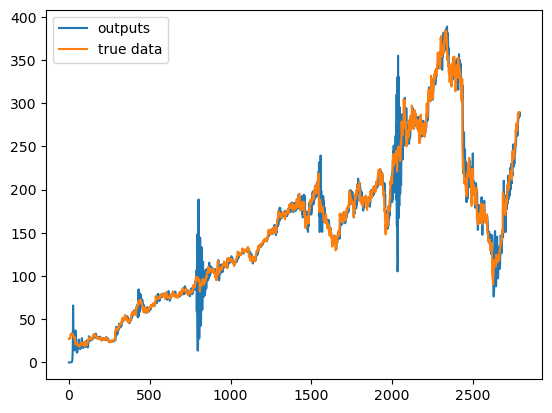

In [73]:
### PLOT TRAIN DATA

import matplotlib.pyplot as plt
backcast, forecast = model(torch.Tensor(x_train[1]))

bc = backcast.squeeze().tolist()
fc = forecast.squeeze().tolist()
pred = bc + fc

actual = x_train[1] + y_train[1]

yyy = [x[0] for x in y_train]
print(yyy)
print(train_outputs[:2800])

plt.plot([0,0,0,0,0] + train_outputs[:2800], label="outputs")

plt.plot(yyy, label="true data")
plt.legend()


In [74]:
##Eval
outputs = []


model.eval()

with torch.no_grad():
    #for i in range(len(x_test)):
    #    inp = torch.Tensor(x_test[i])
    #    print(inp)
    #    backcast, for_c = model(inp)
    #    print(backcast)
    #    print(for_c)
    #    outputs.append(for_c.squeeze().tolist()[0])

    for i in range(len(x_test)):
        x = torch.Tensor(x_test[i])
        y = torch.Tensor(y_test[i])
        optimizer.zero_grad()
        backcasts, forecasts = model(x)
        outputs.append(forecasts.squeeze().tolist()[0])

yyy_test = [x[0] for x in y_test]
print(len(yyy_test))


143


[313.2225646972656, 314.2908630371094, 314.2652893066406, 313.6153259277344, 312.4111633300781, 312.9644470214844, 314.8448486328125, 316.7035217285156, 318.08660888671875, 317.7625427246094, 317.5088195800781, 318.6053161621094, 320.3857421875, 322.5559997558594, 323.5530090332031, 322.2073059082031, 320.1903076171875, 317.9757080078125, 316.331298828125, 314.7483825683594, 312.8676452636719, 309.7948303222656, 306.6958923339844, 304.2447204589844, 302.5205993652344, 301.78546142578125, 300.57501220703125, 298.8872985839844, 297.9431457519531, 297.5013427734375, 298.3921203613281, 300.1388854980469, 301.1686706542969, 302.1359558105469, 302.8219909667969, 303.6540222167969, 305.690673828125, 307.3353576660156, 308.123291015625, 309.4435729980469, 310.53900146484375, 310.8541259765625, 311.2477722167969, 311.47021484375, 310.8651123046875, 310.7442321777344, 310.0894470214844, 309.1861572265625, 308.6379699707031, 307.7489318847656, 307.8481140136719, 308.4540100097656, 308.46359252929

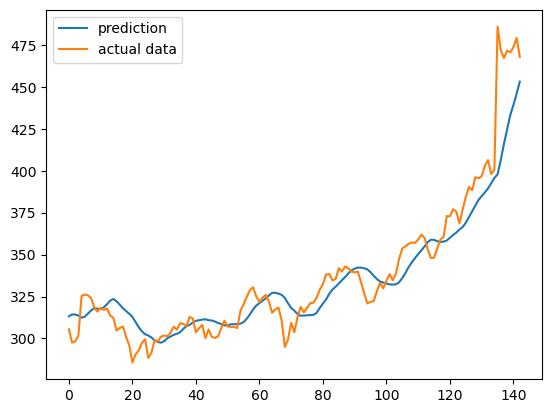

In [75]:

plt.plot( outputs, label = "prediction")
plt.plot(yyy_test, label="actual data")
plt.legend()
print(outputs)

[1.4038352966308594, 0.22256073355674744, -0.40992799401283264, 0.9146678447723389, 0.39541685581207275, 1.6140048503875732, 0.5639277696609497, 0.1736406534910202, -0.7438913583755493, -0.9607245922088623]
[0.6439663171768188, 0.9493489265441895, -2.5803475379943848, 0.3350991904735565, 0.5880723595619202, -1.6856950521469116, -0.8008220195770264, 1.7248530387878418, 0.7421126365661621, 0.2551595866680145]
tensor([11.1393, 11.1553, 11.2155, 11.2003, 11.1881],
       grad_fn=<SqueezeBackward0>)


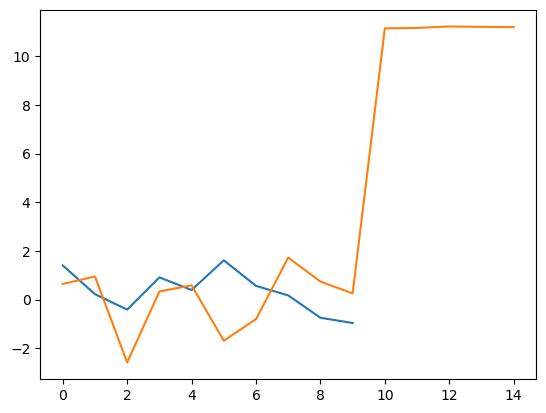

In [76]:
##Synthetic data
import matplotlib.pyplot as plt
inp_data = torch.randn(1, 1, backcast_length)
print(inp_data.squeeze().tolist())
backcast, forecast = model(inp_data)

print(backcast.squeeze().tolist())
print(forecast.squeeze())
bc = backcast.squeeze().tolist()
fc = forecast.squeeze().tolist()
pred = bc + fc

plt.plot(inp_data.squeeze().tolist())
plt.plot(pred)
